### Marketing Campaign Response Prediction

Source: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

Given subjects in a marketing campaign, let's try to predict whether a given subject will respond to the campaign.

We will use a Tensorflow neural network to make our predictions. 

### Getting Started

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

2024-07-31 11:37:30.169038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
data = pd.read_csv('marketing_campaign.csv', delimiter=';')
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
data.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

### Preprocessing

In [15]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column, dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [18]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop ID column
    df = df.drop('ID', axis=1)

    # Fill missing Income values with column mean
    df['Income'] = df['Income'].fillna(df['Income'].mean())

    # Date encoding
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
    df['Year_Customer'] = df['Dt_Customer'].apply(lambda x: x.year)
    df['Month_Customer'] = df['Dt_Customer'].apply(lambda x: x.month)
    df['Day_Customer'] = df['Dt_Customer'].apply(lambda x: x.day)
    df = df.drop('Dt_Customer', axis=1)

    # One Hot encoding
    for column in ['Education', 'Marital_Status']:
        df = onehot_encode(df, column=column)

    # Split df into X and y
    y = df['Response']
    X = df.drop('Response', axis=1)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [20]:
X_train

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Year_Customer,Month_Customer,Day_Customer,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
1747,-1.913598,0.666182,-0.818551,-0.928565,-0.943047,0.940445,-0.000399,0.118913,-0.058848,-0.242557,1.899016,-0.670921,0.670017,0.444401,2.197888,-1.327203,-0.267900,-0.280008,-0.280008,-0.263775,-0.113666,-0.101535,0.0,0.0,-0.071042,0.749737,1.397448,-0.304439,-0.157596,-1.003834,2.242938,-0.536056,-0.035737,-0.043783,-0.332388,1.265042,-0.535070,-0.589134,-0.181489,-0.025262
115,-0.573780,-0.073000,1.038884,0.909806,-0.736818,-0.715194,-0.626743,-0.641544,-0.676671,-0.627602,-0.309914,-0.151413,-0.725185,-0.562565,-0.848420,0.297986,-0.267900,-0.280008,-0.280008,-0.263775,-0.113666,-0.101535,0.0,0.0,-0.071042,0.749737,-0.632170,-0.304439,-0.157596,0.996181,-0.445844,-0.536056,-0.035737,-0.043783,-0.332388,-0.790487,1.868913,-0.589134,-0.181489,-0.025262
1739,0.179867,-0.459033,1.038884,-0.928565,-1.046162,-0.840260,-0.626743,-0.685248,-0.676671,-0.531341,-0.774952,-0.670921,-1.073985,-0.898221,-0.848420,1.110581,-0.267900,-0.280008,-0.280008,-0.263775,-0.113666,-0.101535,0.0,0.0,-0.071042,1.616052,-0.519414,-0.304439,-0.157596,-1.003834,-0.445844,1.865476,-0.035737,-0.043783,-0.332388,1.265042,-0.535070,-0.589134,-0.181489,-0.025262
336,-0.071349,1.074137,-0.818551,-0.928565,-1.321134,1.467509,3.181427,0.547217,0.631660,1.682671,-0.251784,-0.670921,2.414019,0.444401,0.065472,-0.514609,-0.267900,3.571328,3.571328,3.791114,-0.113666,-0.101535,0.0,0.0,-1.517709,1.616052,-1.083196,-0.304439,-0.157596,0.996181,-0.445844,-0.536056,-0.035737,-0.043783,3.008535,-0.790487,-0.535070,-0.589134,-0.181489,-0.025262
2031,-1.159951,0.684143,-0.818551,0.909806,-1.527363,0.032226,0.225084,0.673960,0.159207,-0.483210,1.937769,0.368095,1.018818,-0.226910,1.588626,-0.108311,-0.267900,-0.280008,-0.280008,-0.263775,-0.113666,-0.101535,0.0,0.0,-0.071042,1.327280,1.171935,-0.304439,-0.157596,0.996181,-0.445844,-0.536056,-0.035737,-0.043783,-0.332388,1.265042,-0.535070,-0.589134,-0.181489,-0.025262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,-0.155087,0.841743,-0.818551,0.909806,0.569301,0.764756,1.477772,0.014023,-0.222389,2.308370,1.375848,-0.151413,-0.027584,1.451367,2.197888,-1.327203,-0.267900,-0.280008,-0.280008,-0.263775,-0.113666,-0.101535,0.0,0.0,-1.517709,0.749737,0.608152,-0.304439,-0.157596,0.996181,-0.445844,-0.536056,-0.035737,-0.043783,3.008535,-0.790487,-0.535070,-0.589134,-0.181489,-0.025262
905,0.682299,1.506086,-0.818551,-0.928565,1.566075,0.565246,1.653148,0.975520,2.848553,-0.386949,3.836673,-0.670921,-0.376384,0.444401,1.283995,-2.139798,-0.267900,-0.280008,-0.280008,-0.263775,-0.113666,-0.101535,0.0,0.0,1.375626,-0.694119,-0.744927,-0.304439,-0.157596,0.996181,-0.445844,-0.536056,-0.035737,-0.043783,-0.332388,-0.790487,1.868913,-0.589134,-0.181489,-0.025262
1096,-0.908735,1.263423,-0.818551,0.909806,0.191214,0.803467,-0.451367,0.210693,-0.295074,-0.266622,-0.193655,-0.670921,-0.027584,0.108746,-0.239158,-1.733501,-0.267900,-0.280008,-0.280008,-0.263775,-0.113666,-0.101535,0.0,0.0,1.375626,-0.116577,-1.534223,-0.304439,-0.157596,0.996181,-0.445844,-0.536056,-0.035737,-0.043783,3.008535,-0.790487,-0.535070,-0.589134,-0.181489,-0.025262
235,0.514822,-1.388929,1.038884,-0.928565,0.019356,-0.890882,-0.426313,-0.645914,-0.567643,-0.459145,-0.426173,-0.151413,-0.725185,-0.898221,-0.543789,0.297986,-0.26

In [22]:
X_train.var()

Year_Birth                 1.000638
Income                     1.000638
Kidhome                    1.000638
Teenhome                   1.000638
Recency                    1.000638
MntWines                   1.000638
MntFruits                  1.000638
MntMeatProducts            1.000638
MntFishProducts            1.000638
MntSweetProducts           1.000638
MntGoldProds               1.000638
NumDealsPurchases          1.000638
NumWebPurchases            1.000638
NumCatalogPurchases        1.000638
NumStorePurchases          1.000638
NumWebVisitsMonth          1.000638
AcceptedCmp3               1.000638
AcceptedCmp4               1.000638
AcceptedCmp5               1.000638
AcceptedCmp1               1.000638
AcceptedCmp2               1.000638
Complain                   1.000638
Z_CostContact              0.000000
Z_Revenue                  0.000000
Year_Customer              1.000638
Month_Customer             1.000638
Day_Customer               1.000638
Education_2n Cycle         1

### Training

In [24]:
X_train.shape[1]

40

In [26]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics = [
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2024-07-31 11:50:45.074992: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
40/40 [==============================] - 2s 23ms/step - loss: 0.3897 - accuracy: 0.8596 - auc: 0.6848 - val_loss: 0.3623 - val_accuracy: 0.8822 - val_auc: 0.8285
Epoch 2/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2763 - accuracy: 0.8907 - auc: 0.8795 - val_loss: 0.3291 - val_accuracy: 0.8790 - val_auc: 0.8681
Epoch 3/100
40/40 [==============================] - 0s 8ms/step - loss: 0.2395 - accuracy: 0.9051 - auc: 0.9185 - val_loss: 0.3282 - val_accuracy: 0.8917 - val_auc: 0.8776
Epoch 4/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2197 - accuracy: 0.9139 - auc: 0.9296 - val_loss: 0.3230 - val_accuracy: 0.8854 - val_auc: 0.8829
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2068 - accuracy: 0.9195 - auc: 0.9378 - val_loss: 0.3234 - val_accuracy: 0.8917 - val_auc: 0.8853
Epoch 6/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1894 - accuracy: 0.9266 - auc: 0.9477 - val_loss: 0.3155 - 

### Results

In [28]:
results = model.evaluate(X_test, y_test, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("    Test Accuracy: {:.2f}%".format(results[1] * 100))
print("    Test AUC: {:.5f}".format(results[2]))

    Test Loss: 0.26578
    Test Accuracy: 89.58%
    Test AUC: 0.90258


In [31]:
y_pred = np.array(model.predict(X_test) >= 0.5, dtype=np.int)
y_pred

21/21 [==============================] - 0s 5ms/step


/tmp/ipykernel_69250/2001596427.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.array(model.predict(X_test) >= 0.5, dtype=np.int)


array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

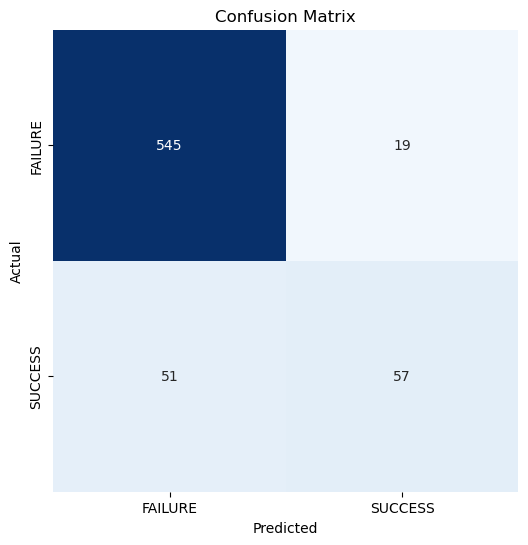

Classification Report:
-----------------------
               precision    recall  f1-score   support

     FAILURE       0.91      0.97      0.94       564
     SUCCESS       0.75      0.53      0.62       108

    accuracy                           0.90       672
   macro avg       0.83      0.75      0.78       672
weighted avg       0.89      0.90      0.89       672



In [32]:
cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=["FAILURE", "SUCCESS"])

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks = np.arange(2) + 0.5, labels=['FAILURE', 'SUCCESS'])
plt.yticks(ticks = np.arange(2) + 0.5, labels=['FAILURE', 'SUCCESS'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n-----------------------\n", clr)